In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784', version =1, as_frame=False)
mnist.keys()

c:\Users\unnikris\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist['data'],mnist['target']

In [73]:
X.shape


(70000, 784)

In [5]:
y.shape

(70000,)

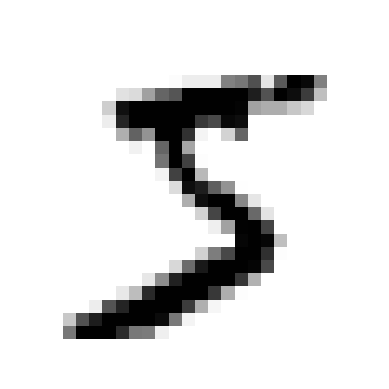

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [96]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### splitting the dataset to try different classification models for the number 5

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#### using **Stochastic Gradient Descent Classifier**

In [11]:
from sklearn.linear_model import SGDClassifier

In [12]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

#### The value **42** is commonly used as a "joke" or reference to the book "The Hitchhiker's Guide to the Galaxy" by Douglas Adams, where the number **42** is described as the "Answer to the Ultimate Question of Life, the Universe, and Everything."

In [13]:
sgd_clf.predict([some_digit])

array([ True])

#### performing Stratified Sampling using StratifiedKFold to cross-validate and measure the accuracy of **Stochastic Gradient Descent Classifier** works on the dataset

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


In [15]:
skfolds = StratifiedKFold(n_splits=3, shuffle= True, random_state=42)


In [16]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    print(train_index, test_index)
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

[    1     3     4 ... 59994 59996 59998] [    0     2     6 ... 59995 59997 59999]
0.9669
[    0     2     3 ... 59997 59998 59999] [    1    10    11 ... 59988 59989 59991]
0.91625
[    0     1     2 ... 59995 59997 59999] [    3     4     5 ... 59994 59996 59998]
0.96785


In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train, cv=3 , scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

#### this indicates **Stochastic Gradient Descent Classifier** provides over 90% accuracy. Even though in this case we are only checking for the number 5. Looking at the dataset the number 5 is only 10% of the whole data set so this accuracy doesnt make much sense 

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [19]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### 👆
#### correct non-5s(true negatives), wrongly classified as 5s(false positives)    
#### wrong non-5s(false negative), correct 5s (true positives)

#### non-5s --> negative class
#### 5s     --> positive class

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [22]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [24]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [25]:
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

#### Precision/Recall Tradeoff

In [26]:
threshold = 0
y_some_digit_pred = (y_score>threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold = 8000
y_some_digit_pred = (y_score>threshold)
y_some_digit_pred

array([False])

#### if u **increase** the threshold **precision increases** and **recall decreases**
#### if u **decrease** the threshold **precision decreases** and **recall increases**

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [29]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
precisions, recalls, thresholds

(array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]))

In [31]:
def plot_pre_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds,recalls[:-1], "g-", label = "Recall")

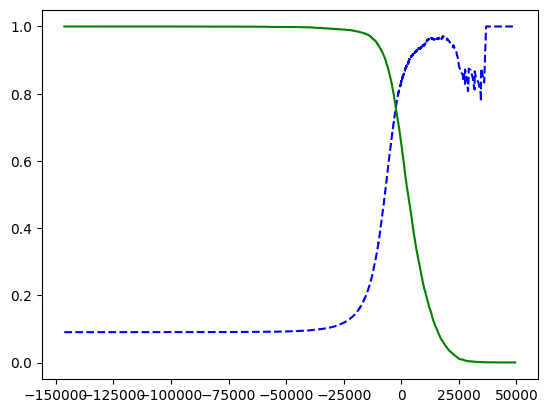

In [32]:
plot_pre_recall_vs_threshold(precisions, recalls, thresholds)

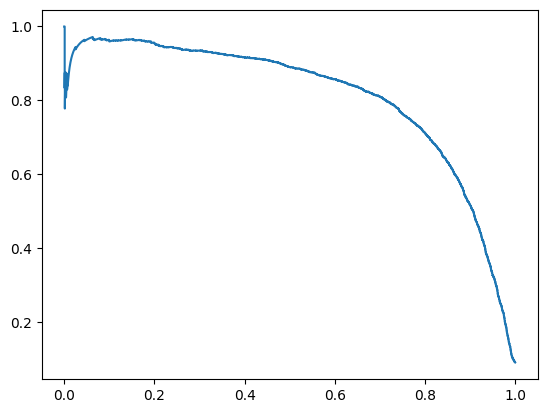

In [33]:
plt.plot(recalls, precisions)

#### So precision starts to fall around 80% recall

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90 )


0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [38]:
from sklearn.metrics import roc_curve

In [39]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

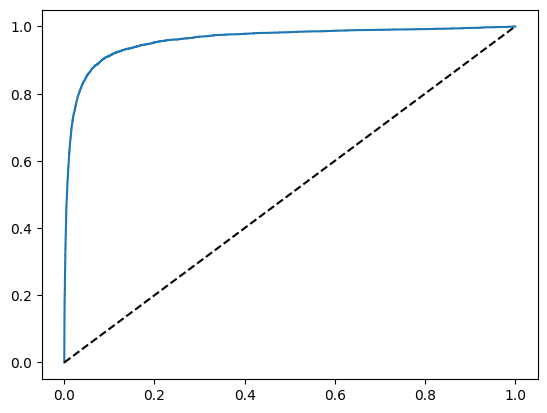

In [40]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr,tpr, label = label)
    plt.plot([0,1], [0,1], 'k--')


plot_roc_curve(fpr,tpr)
plt.show()

In [41]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [44]:
y_scores_forest = y_probas_forest[:,1]    #probability of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

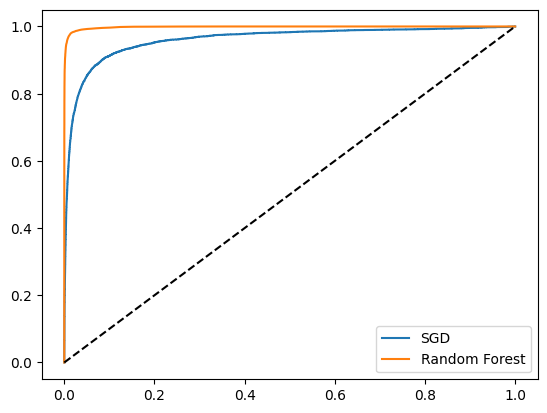

In [45]:
plt.plot(fpr,tpr, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [47]:
from sklearn.svm import SVC

In [48]:
sv_clf = SVC()
sv_clf.fit(X_train, y_train)
sv_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
some_digit_scores = sv_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
sv_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
from sklearn.multiclass import OneVsRestClassifier

In [53]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [55]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [56]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [57]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled,y_train, cv = 3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

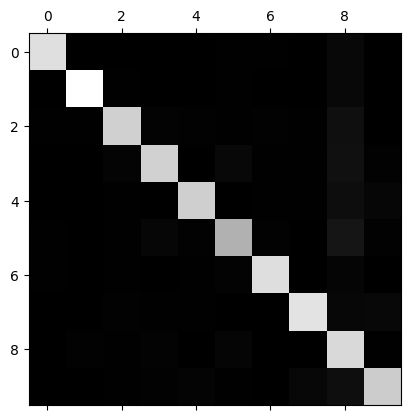

In [61]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

#### 👆 The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5 in dataset or that the classification doesnt work very well on 5s as other digits. to verify each of the case 👇

In [62]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums

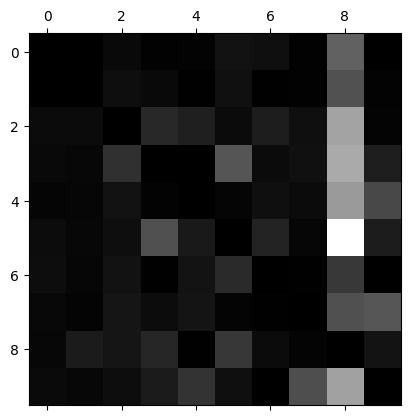

In [63]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

#### what if we need to classify multiple objects in same frame 👇

## **Multilabel Classification**

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]


knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [66]:
knn_clf.predict([some_digit])

array([[False,  True]])

##### as 5 is not large than 7 it gave false and its odd hence true

In [67]:
y_train_pred_knn = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_pred_knn, average = 'macro')

0.976410265560605

## MultiOutput Classification

In [68]:
noise_train = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train + noise_train
noise_test = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise_test 
y_train_mod = X_train
y_test_mod = X_test


In [69]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
            interpolation="nearest")
    plt.axis("off")

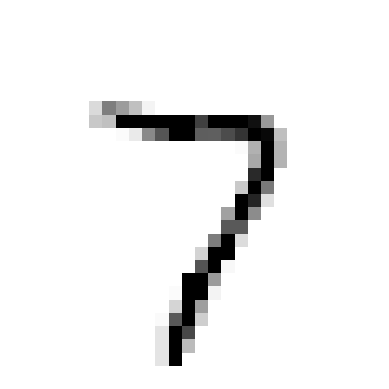

In [70]:
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ['uniform','distance'], 'n_neighbors': [3,4,5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv = 5, verbose=3)

In [75]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=   4.4s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=   4.4s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   3.8s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   3.7s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=   3.6s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   3.3s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   3.3s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   3.5s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   3.4s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=   3.3s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=   3.6s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [76]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [77]:
grid_search.best_score_

0.9716166666666666

In [78]:
from sklearn.metrics import accuracy_score
y_pred_knn = grid_search.predict(X_test)
accuracy_score(y_test, y_pred_knn)


0.9714

### Data Augmentation

In [81]:
from scipy.ndimage.interpolation import shift

C:\Users\unnikris\AppData\Local\Temp\ipykernel_14884\987197595.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [118]:
def data_aug(image, dx,dy):
    image = image.reshape((28,28))
    shifted_image = shift(image,[dy,dx], cval = 0, mode="constant")
    return shifted_image.reshape([-1])

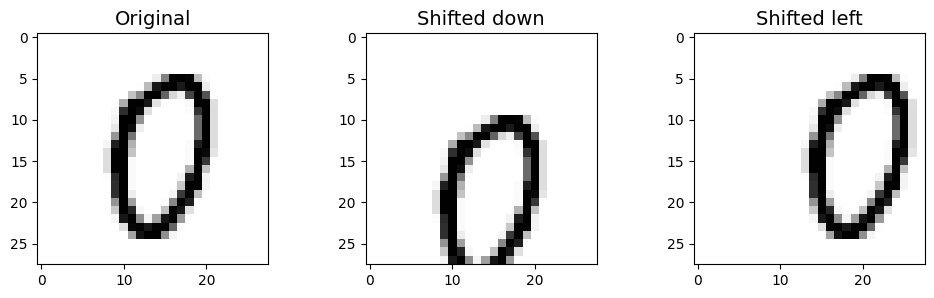

In [120]:
image = X[1000]
shifted_image_down = data_aug(image, 0,5)
shifted_image_left = data_aug(image, 5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [121]:
X_train_aug = [image for image in X_train]
y_train_aug = [label for label in y_train]

for dx, dy in ((1,1), (-1,0), (0,1), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_aug.append(data_aug(image, dx, dy))
        y_train_aug.append(label)

X_train_aug = np.array(X_train_aug,dtype=object)
y_train_aug = np.array(y_train_aug)

In [122]:
shuffle_index = np.random.permutation(len(X_train_aug))
X_train_aug = X_train_aug[shuffle_index]
y_train_aug = y_train_aug[shuffle_index]

array([[8, 3, 9, ..., 3, 9, 6]], dtype=uint8)

In [123]:
knn_clf_aug = KNeighborsClassifier(**grid_search.best_params_)

In [124]:
knn_clf_aug.fit(X_train_aug, y_train_aug)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [126]:
y_pred_knn_aug = knn_clf_aug.predict(X_test)
accuracy_score(y_test, y_pred_knn_aug)

0.976